# Mixture Density Networks

## Part 1: Inverse Problem Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set seed to ensure reproducibility
np.random.seed(42)

n = 200
x = np.sort(np.random.uniform(0, 1, size=(n,)))

#### Generate Target Data (Considering Forward Problem)

$$
t = x_n + 0.3 sin(2\pi x_n) + e \\
$$
$$
e \sim \text{Uniform}(-0.1, 0.1)
$$

In [3]:
t = x + 0.3 * np.sin(2 * np.pi * x) + np.random.uniform(-0.1, 0.1, size=(n,))

#### Plot Forward Problem Data

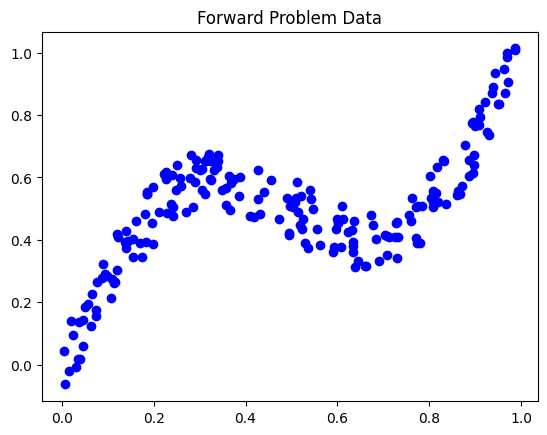

In [4]:
plt.plot(x, t, 'bo')
plt.title('Forward Problem Data')
plt.show()

#### Plot Inverse Problem Data

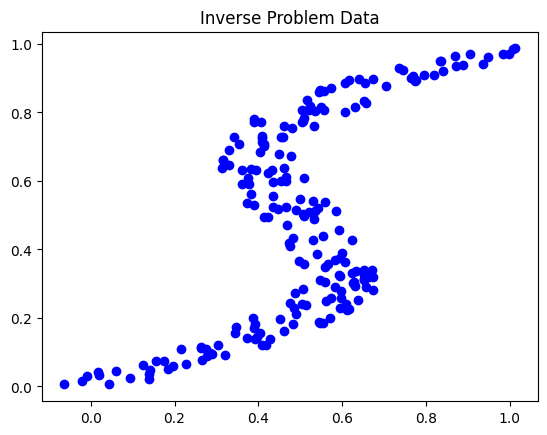

In [5]:
# on swapping t and x
plt.plot(t, x, 'bo')
plt.title('Inverse Problem Data')
plt.show()

## Part 2: Least Squares for both Forward and Inverse Data

#### Create DataLoader

In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# we want input to be shaped like (n, 1), rows are samples, columns are features
batch_size=50
forward_dl = DataLoader(TensorDataset(torch.Tensor(x).view(-1, 1), torch.Tensor(t)), batch_size=batch_size, shuffle=True)
inverse_dl = DataLoader(TensorDataset(torch.Tensor(t).view(-1, 1), torch.Tensor(x)), batch_size=batch_size, shuffle=True)

# sanity check
assert next(iter(forward_dl))[0].shape == torch.Size([batch_size, 1])
assert next(iter(forward_dl))[1].shape == torch.Size([batch_size])

/Users/nikhilshenoy/miniconda3/envs/ml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Create Network

In [7]:
import torch
import torch.nn as nn

In [8]:
class SimpleLinearRegression(nn.Module):
    '''Initializes Linear Regression Network'''
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_units: int = 100):
        super(SimpleLinearRegression, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_units), # first hidden layer
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units), # second hidden layer
            nn.ReLU(),            
            nn.Linear(hidden_units, output_dim), # output layer,
        )
    
    def forward(self, x):
        return self.net(x).squeeze()

In [9]:
net = SimpleLinearRegression()

In [13]:
net

SimpleLinearRegression(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

#### Create Training Pipeline

In [14]:
from torch.utils.data import DataLoader, TensorDataset

In [15]:
def fit(model, dl, optimizer, epochs=10):
    # set to training mode
    model.train()
    
    # intialize loss function
    loss_fn = nn.MSELoss()
    
    # iterate over epochs and batches
    epoch_losses = []
    num_batches = len(dl)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, batch in enumerate(dl):
            x, y = batch
            
            # compute loss
            loss = loss_fn(model(x), y)

            # backprop / optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update epoch_loss
            epoch_loss += loss.detach().item()
            
        # add to epoch_losses
        epoch_losses.append(epoch_loss / num_batches)
    
    # set to validation model
    model.eval()
    predictions = []
    x_vals = []
    
    # constructing datapoints to plot least-squares curve
    pred_dl = DataLoader(TensorDataset(torch.arange(0, 1, 0.0001).unsqueeze(1)), batch_size=100)
    with torch.no_grad(): # do not compute gradients while evaluating
        for batch_idx, batch in enumerate(pred_dl):
            x = batch[0]
            
            # storing so that plots can be made
            predictions.extend(model(x).tolist())
            x_vals.extend(x.squeeze().tolist())
    
    return x_vals, predictions, epoch_losses

#### Fit Forward Problem Data

In [21]:
model = SimpleLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 500
x_vals, predictions, epoch_losses = fit(
    model, 
    forward_dl,
    optimizer, 
    epochs=epochs
)

# plt.plot(np.arange(epochs), epoch_losses)
# plt.title('Epoch Loss')
# plt.show()

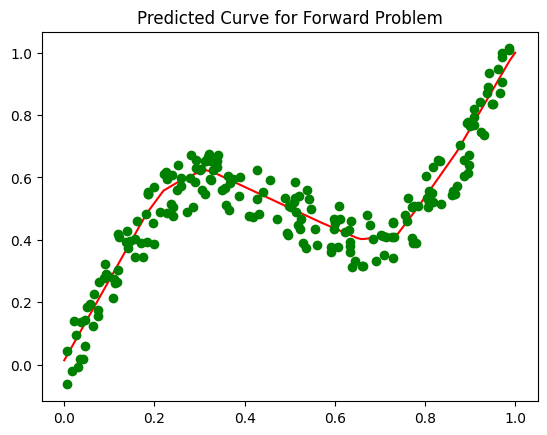

In [22]:
plt.plot(x_vals, predictions, 'r')
plt.plot(x, t, 'go')
plt.title('Predicted Curve for Forward Problem')
plt.show()

#### Fit Inverse Problem Data

In [23]:
model = SimpleLinearRegression(hidden_units=250) # have increased hidden_units to allow it to overfit
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
epochs = 1000 # have added more epochs, to allow more time to overfit
x_vals, predictions, epoch_losses = fit(
    model, 
    inverse_dl,
    optimizer, 
    epochs=epochs
)

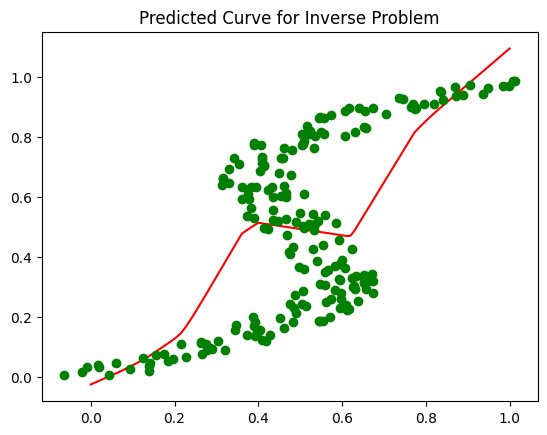

In [24]:
plt.plot(x_vals, predictions, 'r')
plt.plot(t, x, 'go')
plt.title('Predicted Curve for Inverse Problem')
plt.show()

## Part 3: Mixture Density Networks